['car_sale']
   condition_norm  odometer_norm  age_norm
0            0.98       0.006012       0.0
1            0.84       0.007254       0.0
2            0.94       0.007840       0.0
3            0.88       0.008282       0.0
4            0.86       0.008328       0.0
0    0.98
1    0.84
2    0.94
3    0.88
4    0.86
Name: quality, dtype: float64


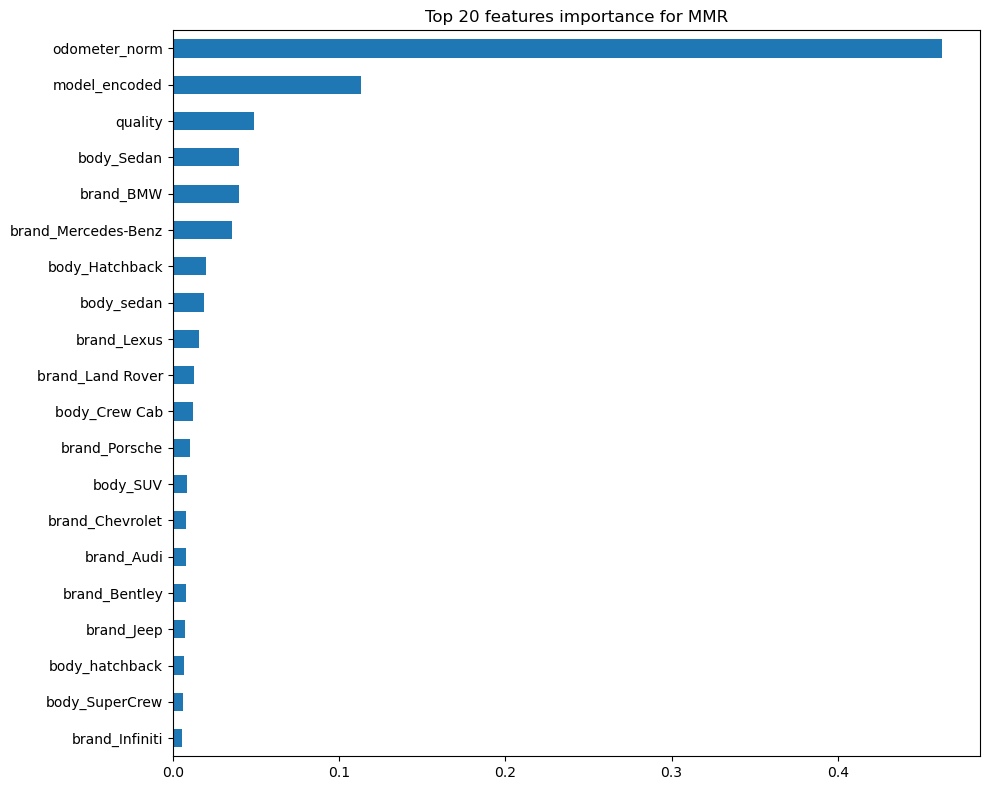

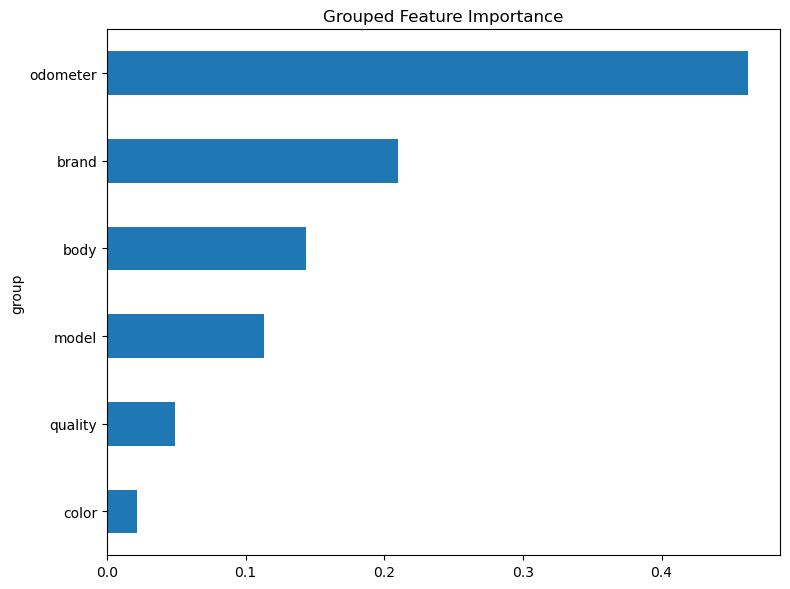

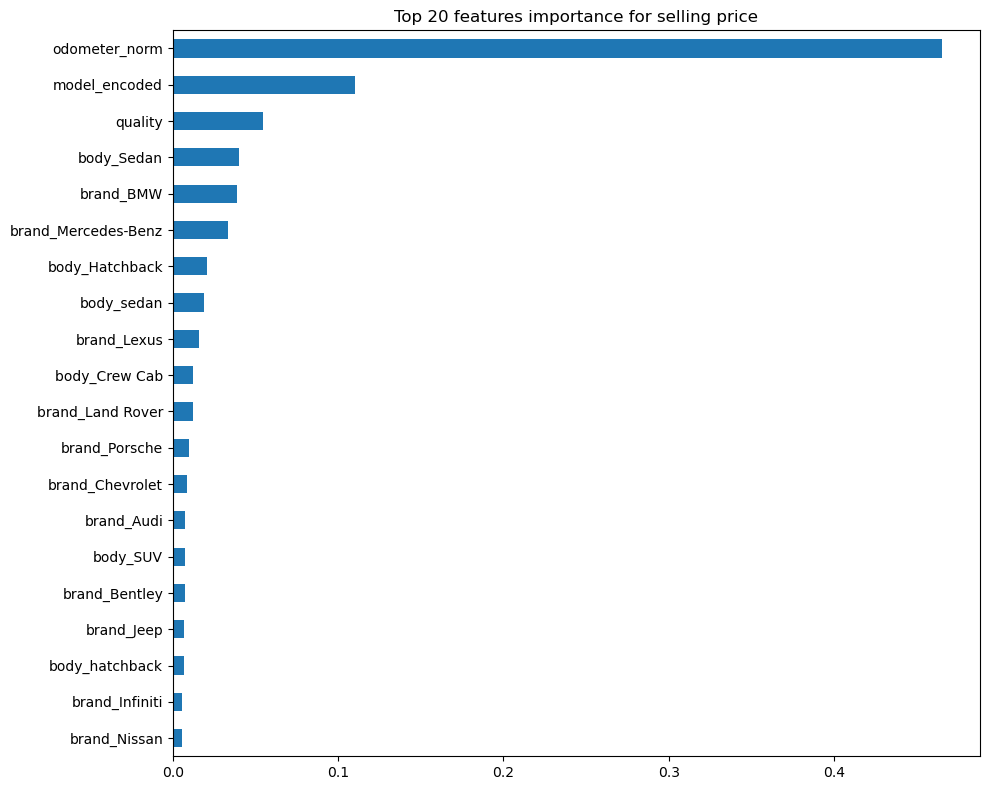

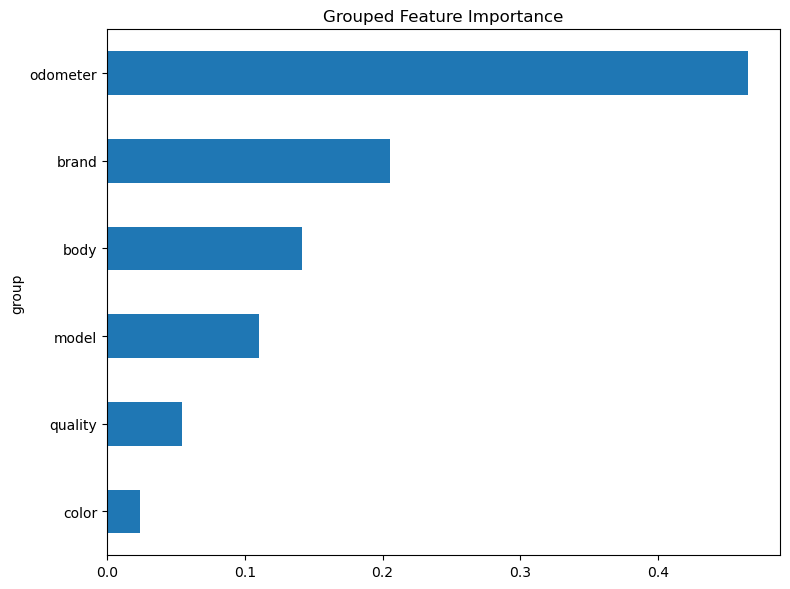

In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import shap

# upload file and prepare features to normalize
def upload_file(file_path, sheet_name='car_sale'):
    file=pd.ExcelFile(file_path)
    print(file.sheet_names)
    df=pd.read_excel("mmr.xlsx", sheet_name=sheet_name) # load dataset
    features_to_normalize=['condition', 'odometer', 'age']

#Replace placeholder odometer values (999999) in dataset with predicted values
wrong_odo_mask=df['odometer']==999999
df_bad_odo=df[wrong_odo_mask]
df_good_odo=df[~wrong_odo_mask]
features=['age', 'condition']
target='odometer'
x_train=df_good_odo[features]
y_train=df_good_odo[target]
x_predict=df_bad_odo[features]
scaler=StandardScaler()
x_train_s=scaler.fit_transform(x_train) #normalize input features
x_predict_s=scaler.transform(x_predict)
model=LinearRegression() 
model.fit(x_train_s, y_train) #train using linear regression
predicted_odometers=model.predict(x_predict_s) #predict the values of placeholder odometer
predicted_odometers=np.round(predicted_odometers).astype(int) 
print(predicted_odometers[:10])
df.loc[wrong_odo_mask, 'odometer']=predicted_odometers #replace placeholder values with predicted values
print(df.columns.duplicated().sum())
print(df['odometer'].max())

# Normalize selected features
x=df[features_to_normalize].copy()
scaler=MinMaxScaler()
x_norm=scaler.fit_transform(x)
x_norm_df=pd.DataFrame(x_norm, columns=[f"{col}_norm" for col in features_to_normalize])
print(x_norm_df.head())
df = df.drop(columns=['condition_norm', 'age_norm', 'odometer_norm'], errors='ignore') # drop these columns to avoid duplication on multiple runs
df=pd.concat([df, x_norm_df], axis=1) # add normalized values of features to df

# combine age and condition features into a single feature: 'quality'
df['quality']=df['condition_norm']+df['age_norm']
print(df['quality'].head())

# Use Random Forest Regressor to find out feature importance in generating MMR
df['model_encoded']=df['model'].map(df['model'].value_counts()) # use frequency encoding for models
df=pd.get_dummies(df, columns=['brand', 'body', 'color'], drop_first=True) # use one hot encoding for other features
features=['quality', 'odometer_norm', 'model_encoded'] + [col for col in df.columns if col.startswith('brand_') or col.startswith('body_') or col.startswith('color_')]
x=df[features]
y=df['mmr']
model=RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(x,y)
importances=pd.Series(model.feature_importances_, index=x.columns)
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10,8), title='Top 20 features importance for MMR')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
importances_df = pd.DataFrame({'feature': x.columns, 'importance': model.feature_importances_})
importances_df['group'] = importances_df['feature'].str.extract(r'(^[^_]+)')  # gets 'brand', 'body', etc.
group_importance = importances_df.groupby('group')['importance'].sum().sort_values(ascending=True)
group_importance.plot(kind='barh', figsize=(8, 6), title='Grouped Feature Importance') # plot feature importance by group
plt.tight_layout()
plt.show()

# Use Random Forest Regressor to find out feature importance in generating sellingprice
z=df['sellingprice']
model=RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x,z)
importances=pd.Series(model.feature_importances_, index=x.columns)
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10,8), title='Top 20 features importance for selling price')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
importances_df = pd.DataFrame({'feature': x.columns, 'importance': model.feature_importances_})
importances_df['group'] = importances_df['feature'].str.extract(r'(^[^_]+)')  # gets 'brand', 'body', etc.
group_importance = importances_df.groupby('group')['importance'].sum().sort_values(ascending=True)
group_importance.plot(kind='barh', figsize=(8, 6), title='Grouped Feature Importance') # plot feature importance by group
plt.tight_layout()
plt.show()